In [40]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [41]:
import numpy as np
import pandas as pd

In [42]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [43]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [79]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [80]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [81]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [82]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [83]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


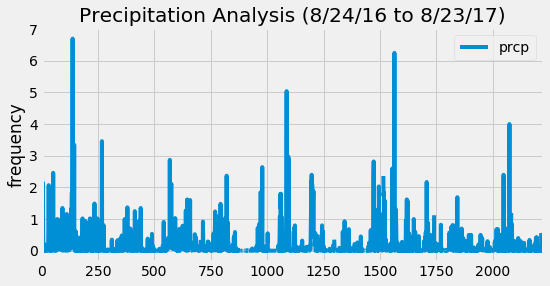

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


#design a query to retrieve the last 12 months of precipitation data
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

# Calculate the date 1 year ago from the last data point in the database

#calc the date one year from today

one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)


# Perform a query to retrieve the data and precipitation scores

prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.head()

# Sort the dataframe by date

prcp_data_df.set_index('date').head()

# Use Pandas Plotting with Matplotlib to plot the data

ax = prcp_data_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel('frequency')
plt.show()


![precipitation](Images/precipitation.png)

In [85]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [86]:
# Design a query to show how many stations are available in this dataset?

locations = session.query(Measurement).group_by(Measurement.station).count()
print(locations)

9


In [87]:
# What are the most active stations? (i.e. what stations have the most rows)?

active_stations_locations = session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

print(f"Most active stations:")
active_stations_df = pd.DataFrame(active_stations_locations, columns=['Station Name', "Observation Count"])
active_stations_df

# List the stations and the counts in descending order.


Most active stations:


,Station Name,Observation Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [93]:
# Using the station id from the previous query, calculate the lowest temperature recorded,

most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    limit(1).scalar()

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*sel).\
    filter(Measurement.station == most_active_station).\
    group_by(Measurement.station).\
    all()

# highest temperature recorded, and average temperature most active station?
temp_obs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active_station).\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


In [94]:
most_active_station

'USC00519281'

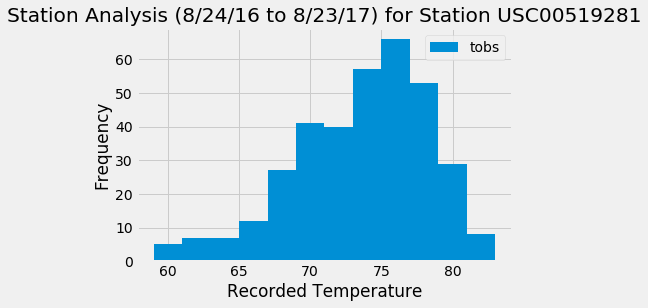

In [97]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.hist(temp_obs_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active_station)
plt.legend(["tobs"])
plt.show()

In [98]:
![precipitation](Images/station-histogram.png)

/bin/sh: -c: line 0: syntax error near unexpected token `Images/station-histogram.png'
/bin/sh: -c: line 0: `[precipitation](Images/station-histogram.png)'


In [99]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [101]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

Trip_start_date = input("Enter the trip start date in 'YYYY-MM-DD' format: ")
Trip_end_date = input("Enter the trip end date in 'YYYY-MM-DD' format: ")

Enter the trip start date in 'YYYY-MM-DD' format: 2018-07-04
Enter the trip end date in 'YYYY-MM-DD' format: 2018-07-15


[(69.0, 78.11842105263158, 82.0)]


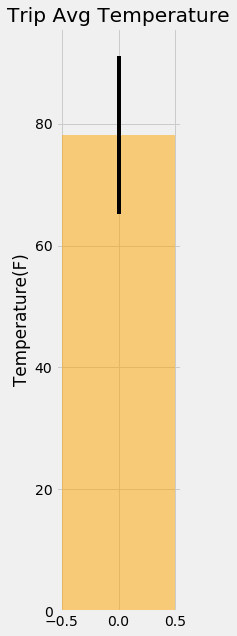

In [103]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

Struct = dt.date.today()
Trip_start_date_dateformat = Struct.replace(year=int(Trip_start_date[:4]),month=int(Trip_start_date[5:7]),day=int(Trip_start_date[8:]))
Previous_Trip_start_date = Trip_start_date_dateformat - dt.timedelta(days=365)
Previous_Trip_start_date = Previous_Trip_start_date.strftime("%Y-%m-%d")
Previous_Trip_start_date
Trip_end_date_dateformat = Struct.replace(year=int(Trip_end_date[:4]),month=int(Trip_end_date[5:7]),day=int(Trip_end_date[8:]))
Previous_Trip_end_date = Trip_end_date_dateformat - dt.timedelta(days=365)
Previous_Trip_end_date = Previous_Trip_end_date.strftime("%Y-%m-%d")
Previous_Trip_end_date

Result = calc_temps(Previous_Trip_start_date, Previous_Trip_end_date)
print(Result)

tmin = Result[0][0]
tavg = Result[0][1]
tmax = Result[0][2]
y_err = tmax-tmin

plt.figure(figsize=(2,10))
plt.bar(0,tavg,yerr=y_err,align="center",width=1,color="orange",alpha=0.5)
plt.ylim=(0,120)
plt.ylabel("Temperature(F)")
plt.title("Trip Avg Temperature")
plt.savefig("Resources/3_Trip_Avg_Temp_Analysis.jpg")
plt.show()

In [105]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

Rainfall = func.avg(Measurement.prcp).label("Rainfall")
ly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation, \
                            func.avg(Measurement.prcp).label("Rainfall")).\
                filter(Measurement.station == Station.station).filter(Measurement.date >= '2011-02-28').\
                filter(Measurement.date <= '2011-03-05').group_by(Measurement.station).order_by(Rainfall.desc())


index = 0
for rf in ly_rainfall:
    print(ly_rainfall[index])
    index = index + 1                  


('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.5825)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.392)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.37166666666666665)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.365)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.24166666666666667)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.24)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.22999999999999998)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.126)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


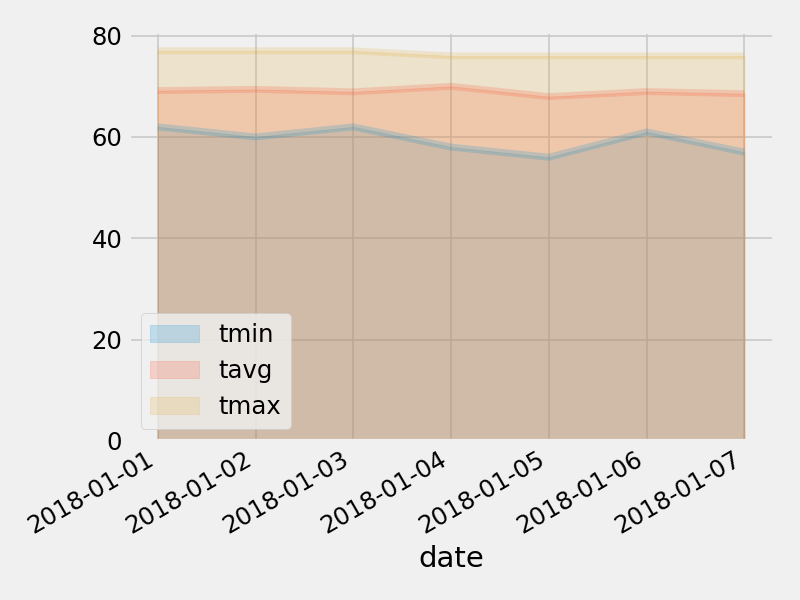

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
